# Heatwave Scenario Generation — Visualisation Example

This notebook demonstrates the **bias-corrected delta-mapping** pipeline
for generating future heatwave weather profiles, using functions defined
in [`test_heatwaves_generation.py`](./test_heatwaves_generation.py).

| # | Section | Description |
|---|---------|-------------|
| 1 | [Load Weather Datasets](#1) | Open ERA5 reanalysis and RCP 4.5 projections |
| 2 | [Network & Spatial Extent](#2) | Load PyPSA network and determine bounding box |
| 3 | [Configuration & Data Slicing](#3) | Select years / month and slice to country extent |
| 4 | [Identify Heatwave Days](#4) | Rank historical & future days by severity |
| 5 | [Variable & Colour Setup](#5) | Pick weather variable and build colourmap |
| 6 | [Spatial Maps](#6) | Bias-corrected snapshots of four scenarios |
| 7 | [National-Average Diurnal Profiles](#7) | 24-hour reference vs heatwave comparison |
| 8 | [Regional Ensemble Profiles](#8) | Per-bus diurnal curves from multiple seed events |

In [1]:
import os
import sys
from datetime import datetime

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Add parent directory to path for project imports
sys.path.append(os.path.join(os.getcwd(), ".."))
from data_config import *                    # noqa: F403
from utils.network_process_utils import *    # noqa: F403
from utils.heatwave_utils import *           # noqa: F403
from utils.plot_utils import *               # noqa: F403

# Helper from the production script
from test_heatwaves_generation import _build_cmap_colors

<a id='1'></a>
## 1. Load Weather Datasets

Open historical ERA5 reanalysis (hourly) and EURO-CORDEX RCP 4.5
projections (3-hourly) for both historical and future periods.

In [2]:
his_era5 = xr.open_dataset(EXTERNAL + "/era5/era5_hourly_summer_2019_2024.nc")
his_rcp45 = xr.open_dataset(EXTERNAL + "/rcp45/rcp45_3hourly_summer_2019_2024.nc")
fut_rcp45 = xr.open_dataset(EXTERNAL + "/rcp45/rcp45_3hourly_summer_2025_2030.nc")

<a id='2'></a>
## 2. Network & Spatial Extent

Load the PyPSA-Eur network for the selected country and derive a
bounding box (with a 0.25° buffer) for spatial slicing.

In [3]:
selected_country = ['BE', 'IT', 'ES', 'FR', 'GB', 'DE', 'PT', 'NL'][2]
os.makedirs(MODELS + f'/heatwave/{selected_country}', exist_ok=True)

network, regions = load_network_EU([selected_country], RATIO)

country_range = [
    network.buses.x.min() - 0.25, network.buses.x.max() + 0.25,
    network.buses.y.min() - 0.25, network.buses.y.max() + 0.25,
]
print(f"Country: {selected_country}  |  "
      f"Buses: {len(network.buses)}  |  "
      f"Bounding box: {[f'{v:.2f}' for v in country_range]}")

Loading EU network from: /Users/liangenming/Desktop/Code/Power-System-Evaluation/HeatAnalysis/data/EU/networks/base_s_75_elec.nc


INFO:pypsa.io:Imported network base_s_75_elec.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


Country: ES  |  Buses: 281  |  Bounding box: ['-9.30', '3.29', '35.96', '43.90']


<a id='3'></a>
## 3. Configuration & Data Slicing

Select the historical / future year and month, then slice all three
datasets to the country extent and interpolate 3-hourly RCP 4.5 data
to hourly resolution.

In [4]:
# Year / month selection
fut_year = 2028
his_year = 2022
heatwave_month = 7  # July

# Date ranges
date_s = datetime(his_year, heatwave_month, 1, 0)
date_e = datetime(his_year, heatwave_month, 30, 23)
fut_date_s = datetime(fut_year, heatwave_month, 1, 0)
fut_date_e = datetime(fut_year, heatwave_month, 30, 23)

# Spatial / temporal slicing
bbox = dict(
    x=slice(country_range[0], country_range[1]),
    y=slice(country_range[2], country_range[3]),
)
his_era5_slice = his_era5.sel(time=slice(date_s, date_e), **bbox)
his_rcp45_slice = his_rcp45.sel(time=slice(date_s, date_e), **bbox)
fut_rcp45_slice = fut_rcp45.sel(time=slice(fut_date_s, fut_date_e), **bbox)

# Interpolate 3-hourly RCP 4.5 data to hourly resolution
his_rcp45_hourly = interpolate_3h_to_1h(his_rcp45_slice)
fut_rcp45_hourly = interpolate_3h_to_1h(fut_rcp45_slice)

<a id='4'></a>
## 4. Identify Heatwave Days

Rank days by a weighted combination of temperature and solar intensity
to identify the most severe heatwave events.  Snapshot times are set to
14:00 (peak afternoon heat).

In [5]:
his_hw_idx, his_hw_dates = find_heatwave_days(
    his_era5_slice, regions, weights=[0.9, 0.1],
)
fut_hw_idx, fut_hw_dates = find_heatwave_days(
    fut_rcp45_hourly, regions, weights=[0.9, 0.1],
)

# Pick the hottest historical day and a near-top future day (14:00)
historical_date = pd.Timestamp(his_hw_dates[his_hw_idx[0]]).replace(hour=14)
future_date = pd.Timestamp(fut_hw_dates[fut_hw_idx[2]]).replace(hour=14)

print(f"Historical heatwave date: {historical_date}")
print(f"Future heatwave date:     {future_date}")

Historical heatwave date: 2022-07-17 14:00:00
Future heatwave date:     2028-07-18 14:00:00


<a id='5'></a>
## 5. Variable & Colour Setup

Select the weather variable to visualise and build the matching
colourmap, scale limits, and colour list.  `vnom_dic`, `cmap_dic`,
and `cbar_lable_dic` are imported from `plot_utils`.

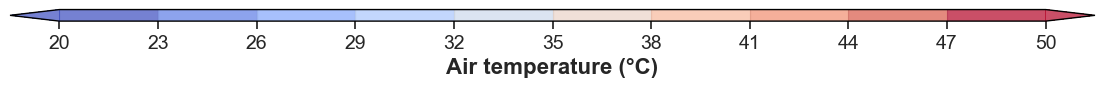

In [6]:
variable = 'temperature'  # Options: 'temperature', 'influx', 'wnd10m', 'wnd100m'

vnom = vnom_dic[variable]
cmap = cmap_dic[variable]
cbar_label = cbar_lable_dic[variable]
cmap_colors = _build_cmap_colors(variable)

# Preview colourbar
create_discrete_temperature_colorbar(
    cmap=cmap, num_levels=vnom[2], vmin=vnom[0], vmax=vnom[1],
    alpha=0.7, label=cbar_label, extend='both', figsize=(14, 0.15),
)
plt.show()

<a id='6'></a>
## 6. Spatial Maps — Bias-Corrected Snapshots

Apply the delta-mapping bias correction to produce a future heatwave
field, then plot all four scenarios as spatial maps and display them
as a single composite figure.

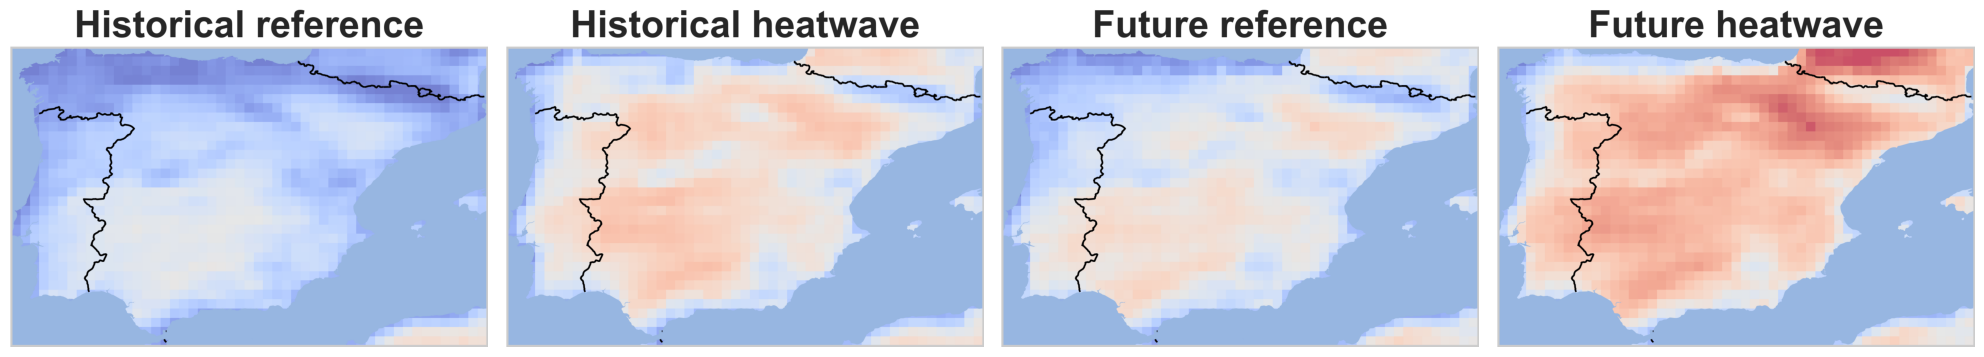

In [7]:
# Bias-correct the future heatwave snapshot
weather_his_hw = his_era5_slice.sel(time=historical_date, method='nearest')
weather_his_bl = his_rcp45_hourly.sel(time=historical_date, method='nearest')
weather_fut_bl = fut_rcp45_hourly.sel(time=future_date, method='nearest')
weather_fut_hw = bias_correction(
    variable, weather_his_hw, weather_his_bl, weather_fut_bl, smooth_grid=2,
)

# Four scenarios to compare
profiles = [
    weather_his_bl[variable], weather_his_hw[variable],
    weather_fut_bl[variable], weather_fut_hw[variable],
]
name_list = [
    'Historical reference', 'Historical heatwave',
    'Future reference', 'Future heatwave',
]

# Save individual spatial maps
for profile, name in zip(profiles, name_list):
    data = profile.data - TK if variable == 'temperature' else profile.data
    lon = profile['x'].data - 0.125
    lat = profile['y'].data - 0.125

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    plt.pcolormesh(
        lon, lat, data, shading='auto', cmap=cmap,
        norm=plt.Normalize(vmin=vnom[0], vmax=vnom[1]), alpha=0.7, zorder=0,
    )
    ax.add_feature(cfeature.OCEAN, zorder=1)
    ax.add_feature(cfeature.BORDERS, zorder=1)
    plt.title(name, fontsize=22, fontweight='bold')
    plt.savefig(
        MODELS + f'/heatwave/{selected_country}/{variable}_{name}.png',
        dpi=300, bbox_inches='tight', pad_inches=0.01,
    )
    plt.close()

# Display saved maps as a single composite
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for idx, name in enumerate(name_list):
    img = plt.imread(
        MODELS + f'/heatwave/{selected_country}/{variable}_{name}.png',
    )
    axes[idx].imshow(img)
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

<a id='7'></a>
## 7. National-Average Diurnal Profiles

Compare the 24-hour nationally averaged weather profiles for
historical and future reference / heatwave conditions.  Shaded
bands highlight the gap between reference and heatwave curves.

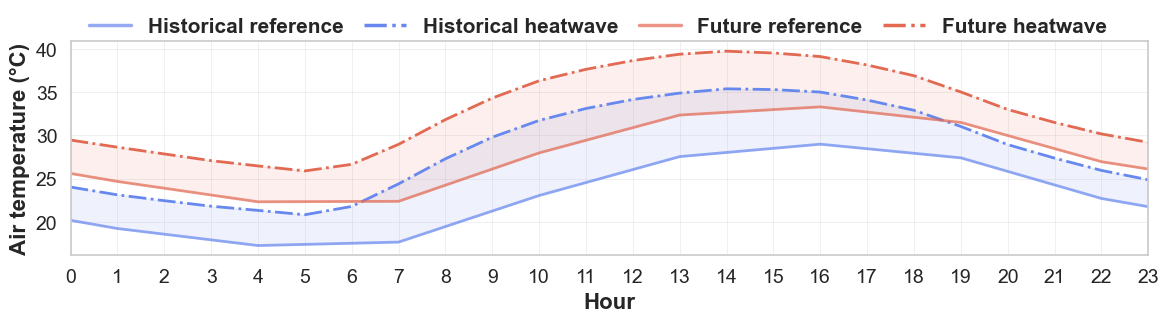

In [8]:
(bus_his_hw, bus_his_bl,
 bus_fut_bl, bus_fut_hw) = temperal_trend_data(
    variable, regions, his_era5_slice, his_rcp45_hourly,
    fut_rcp45_hourly, historical_date, future_date,
)

# National averages (mean across all buses)
nat_his_bl = bus_his_bl.mean(1)
nat_his_hw = bus_his_hw.mean(1)
nat_fut_bl = bus_fut_bl.mean(1)
nat_fut_hw = bus_fut_hw.mean(1)

c_his = cmap_colors[1]
c_fut = cmap_colors[-2]

plt.figure(figsize=(12.5, 3.5))

# Historical band + curves
plt.fill_between(range(24), nat_his_bl, nat_his_hw, alpha=0.1, color=c_his)
plt.plot(nat_his_bl, c=c_his, alpha=0.7, linewidth=2)
plt.plot(nat_his_hw, c=c_his, linestyle='-.', linewidth=2)

# Future band + curves
plt.fill_between(range(24), nat_fut_bl, nat_fut_hw, alpha=0.1, color=c_fut)
plt.plot(nat_fut_bl, c=c_fut, alpha=0.7, linewidth=2)
plt.plot(nat_fut_hw, c=c_fut, linestyle='-.', linewidth=2)

# Legend handles
plt.plot([], label='Historical reference', c=c_his, alpha=0.7, linewidth=2.5)
plt.plot([], label='Historical heatwave', c=c_his, linestyle='-.', linewidth=2.5)
plt.plot([], label='Future reference', c=c_fut, alpha=0.7, linewidth=2.5)
plt.plot([], label='Future heatwave', c=c_fut, linestyle='-.', linewidth=2.5)

plt.xlim(0, 23)
plt.xticks(range(24), fontsize=14)
plt.xlabel('Hour', fontsize=16, fontweight='bold')
plt.ylabel(cbar_label, fontsize=16, fontweight='bold')
plt.legend(
    ncol=4, loc=2, frameon=False, columnspacing=1.0,
    bbox_to_anchor=(0.0, 1.2),
    prop={'size': 15, 'weight': 'bold'},
)
plt.grid(linewidth=0.4, alpha=0.5)
plt.tight_layout()
plt.show()

<a id='8'></a>
## 8. Regional Ensemble Profiles

For a set of randomly sampled bus regions, generate future heatwave
diurnal curves using each of the top-5 historically hottest days as
seed events.  This shows the **ensemble spread** of possible future
heatwave realisations at each location.

In [9]:
N_REGIONS = 3
N_SAMPLES = 5

# Randomly pick bus regions
np.random.seed(2026)
bus_indices = np.random.choice(len(network.buses), N_REGIONS, replace=False)

# Collect heatwave ensembles and track global min / max
hw_list = []
fut_max, fut_min = 0.0, 1e6

for i in his_hw_idx[:N_SAMPLES]:
    hist_sample = pd.Timestamp(his_hw_dates[i])
    _, _, bus_fut_bl_s, bus_fut_hw_s = temperal_trend_data(
        variable, regions, his_era5_slice, his_rcp45_hourly,
        fut_rcp45_hourly, hist_sample, future_date,
    )
    fut_max = np.maximum(fut_max, bus_fut_hw_s[:, bus_indices].max())
    fut_min = np.minimum(fut_min, bus_fut_hw_s[:, bus_indices].min())
    hw_list.append(bus_fut_hw_s)

# Include baseline in y-axis range
fut_max = max(fut_max, bus_fut_bl_s[:, bus_indices].max())
fut_min = min(fut_min, bus_fut_bl_s[:, bus_indices].min())

c_fut = cmap_colors[-2]

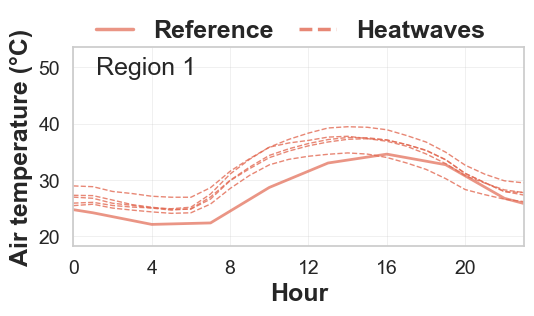

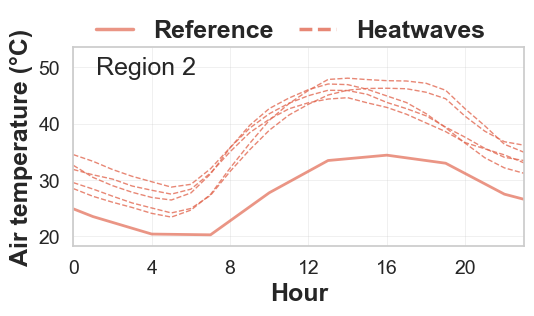

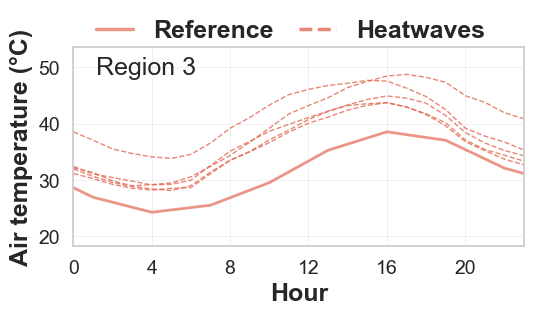

In [10]:
for k, bus_idx in enumerate(bus_indices):
    plt.figure(figsize=(5.5, 3.5))
    plt.plot(bus_fut_bl_s[:, bus_idx], c=c_fut, alpha=0.7, linewidth=2)
    for hw in hw_list:
        plt.plot(hw[:, bus_idx], c=c_fut, linestyle='--', linewidth=1, alpha=0.8)

    # Legend handles
    plt.plot([], label='Reference', c=c_fut, linewidth=2.5, alpha=0.7)
    plt.plot([], label='Heatwaves', c=c_fut, linestyle='--', linewidth=2.5, alpha=0.8)

    plt.xlim(0, 23)
    plt.ylim(fut_min * 0.9, fut_max * 1.1)
    plt.xticks(range(0, 24, 4), fontsize=14)
    plt.xlabel('Hour', fontsize=18, fontweight='bold')
    plt.ylabel(cbar_label, fontsize=18, fontweight='bold')
    plt.grid(linewidth=0.4, alpha=0.5)
    plt.legend(
        ncol=2, loc=2, frameon=False, columnspacing=1,
        handlelength=1.5, bbox_to_anchor=(0, 1.25),
        prop={'size': 18, 'weight': 'bold'},
    )
    plt.text(
        0.05, 0.95, f'Region {k + 1}',
        transform=plt.gca().transAxes, fontsize=18,
        verticalalignment='top', horizontalalignment='left',
    )
    plt.tight_layout()
    plt.show()